<a href="https://colab.research.google.com/github/wildanputra/deeplearningtutorial/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Using Pretrained Inception v3
In this tutorial we will discuss how to classify cats vs dogs images by using transfer learning from a pre-trained network. This will allows us to get higher accuracies than we saw by training our network from scratch.

Sources : 
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb#scrollTo=hRTa3Ee15WsJ

https://colab.research.google.com/github/Hvass-Labs/TensorFlow-Tutorials/blob/master/08_Transfer_Learning.ipynb#scrollTo=0QWRlq7M3nLU


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  1.14.0


# Preprocessing
### Download data cats vs dog

In [0]:
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                   fname="cats_and_dogs_filtered.zip", extract=True)
base_dir, _ = os.path.splitext(zip_file)

68608000/68606236 [==============================] - 1s 0us/step


###Prepare training and validation cats and dogs datasets

In [0]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


### Create Image Data Generator with Image Augmentation
We will use ImageDataGenerator to rescale the images.

To create the train generator, specify where the train dataset directory, image size, batch size and binary classification mode.

The validation generator is created the same way.

In [0]:
image_size = 160 # All images will be resized to 160x160
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Create the base model from the pre-trained inception v3

In [0]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model inception V3
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, 
                                            weights='imagenet', 
                                            input_shape=IMG_SHAPE)

W0704 08:29:45.347123 140419962562432 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


87916544/87910968 [==============================] - 1s 0us/step


## Feature extraction
We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting layer.trainable = False), we prevent the weights in these layers from being updated during training.

In [0]:
base_model.trainable = False

In [0]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Add a classification head
Now let's add a few layers on top of the base model:

In [0]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
  ])

## Compile the model
You must compile the model before training it.

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

W0704 08:30:15.318429 140419962562432 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


These 1.2K trainable parameters are divided among 2 TensorFlow Variable objects, the weights and biases of the two dense layers:

In [0]:
len(model.trainable_variables)

2

### Train the model
After training for 10 epochs, we are able to get ~94% accuracy.

If you have more time, train it to convergence (50 epochs, ~96% accuracy)

In [0]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 187s 3s/step - loss: 0.7150 - acc: 0.5178 - val_loss: 0.7395 - val_acc: 0.6099
Epoch 2/10
62/62 [==============================] - 184s 3s/step - loss: 0.6582 - acc: 0.5991 - val_loss: 0.5205 - val_acc: 0.7671
Epoch 3/10
62/62 [==============================] - 185s 3s/step - loss: 0.6081 - acc: 0.6687 - val_loss: 0.3853 - val_acc: 0.8548
Epoch 4/10
62/62 [==============================] - 184s 3s/step - loss: 0.5660 - acc: 0.7119 - val_loss: 0.3118 - val_acc: 0.8800
Epoch 5/10
62/62 [==============================] - 184s 3s/step - loss: 0.5376 - acc: 0.7337 - val_loss: 0.2440 - val_acc: 0.9113
Epoch 6/10
62/62 [==============================] - 187s 3s/step - loss: 0.5066 - acc: 0.7724 - val_loss: 0.2142 - val_acc: 0.9183
Epoch 7/10
62/62 [==============================] - 186s 3s/step - loss: 0.4961 - acc: 0.7693 - val_loss: 0.1886 - val_acc: 0.9264
Epoch 8/10
62/62 [==============================] - 187s 3s/step - loss: 0.4777 - a

### Learning curves
Let's take a look at the learning curves of the training and validation accuracy / loss, when using the MobileNet V2 base model as a fixed feature extractor.

If you train to convergence (epochs=50) the resulting graph should look like this:



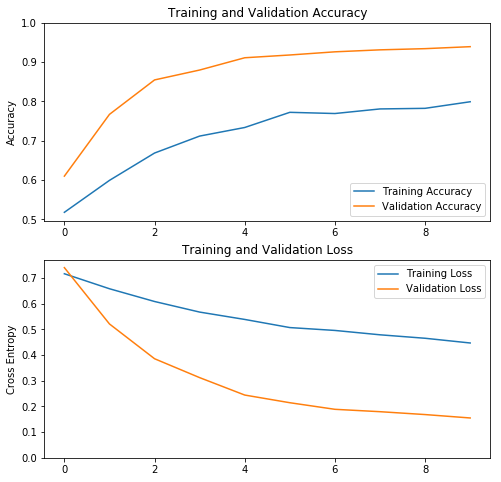

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

# Fine tuning
In our feature extraction experiment, we were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pre-trained model alongside the training of the top-level classifier. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

Note: this should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will just forget everything it has learned.

Additionally, the reasoning behind fine-tuning the top layers of the pre-trained model rather than all layers of the pre-trained model is the following: in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learned very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly more specific to the dataset that the model was trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.

## Un-freeze the top layers of the model
All we need to do is unfreeze the base_model, and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


## Compile the model
Compile the model using a much-lower training rate.

In [0]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 19,628,417
Non-trainable params: 2,176,416
_________________________________________________________________


In [0]:
len(model.trainable_variables)

130

## Continue Train the model
If you trained to convergence earlier, this will get you a few percent more accuracy.

In [0]:
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 399s 6s/step - loss: 0.3400 - acc: 0.8460 - val_loss: 0.1011 - val_acc: 0.9567
Epoch 2/10
62/62 [==============================] - 380s 6s/step - loss: 0.1824 - acc: 0.9380 - val_loss: 0.0956 - val_acc: 0.9556
Epoch 3/10
62/62 [==============================] - 380s 6s/step - loss: 0.0914 - acc: 0.9756 - val_loss: 0.1256 - val_acc: 0.9526
Epoch 4/10
62/62 [==============================] - 381s 6s/step - loss: 0.0535 - acc: 0.9873 - val_loss: 0.1175 - val_acc: 0.9536
Epoch 5/10
62/62 [==============================] - 381s 6s/step - loss: 0.0285 - acc: 0.9919 - val_loss: 0.1672 - val_acc: 0.9405
Epoch 6/10
62/62 [==============================] - 381s 6s/step - loss: 0.0151 - acc: 0.9975 - val_loss: 0.1278 - val_acc: 0.9526
Epoch 7/10
62/62 [==============================] - 379s 6s/step - loss: 0.0113 - acc: 0.9980 - val_loss: 0.1198 - val_acc: 0.9536
Epoch 8/10
62/62 [==============================] - 380s 6s/step - loss: 0.0070 - a

## Learning curves
Let's take a look at the learning curves of the training and validation accuracy / loss, when fine tuning the last few layers of the MobileNet V2 base model, as well as the classifier on top of it. Note the validation loss much higher than the training loss which means there maybe some overfitting.

Note: the training dataset is fairly small, and is similar to the original datasets that MobileNet V2 was trained on, so fine-tuning may result in overfitting.

In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

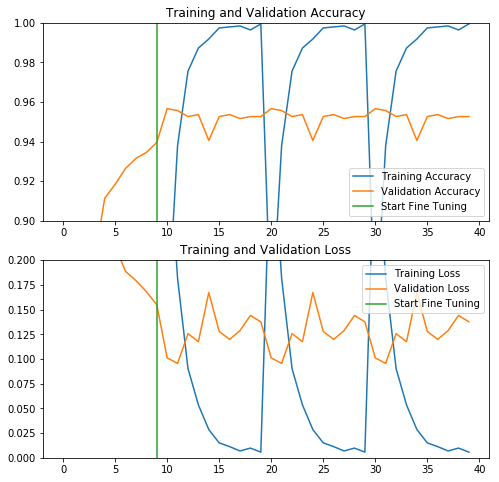

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()